In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sklearn.preprocessing
import sklearn.neural_network

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import h5py
warnings.resetwarnings()
warnings.simplefilter(action='ignore', category=ImportWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=ResourceWarning)

In [3]:
import theano
import theano.tensor as T

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [4]:
import pickle, gzip
f = gzip.open('mnist.pkl.gz','rb')
train_set, valid_set, test_set = pickle.load(f,encoding='latin-1')
f.close()

In [5]:
train_set[0][train_set[0]>=0.5] = 1
train_set[0][train_set[0]<0.5] = 0

test_set[0][test_set[0]>=0.5] = 1
test_set[0][test_set[0]<0.5] = 0

In [6]:
x_train=theano.function([], T.concatenate([train_set[0], valid_set[0]]))()

In [7]:
x_test = theano.function([], theano.shared(test_set[0]))()

In [8]:
n_hidden = 100 # the size of hidden layers in MLP
n_latent = 3 # the dimension of z
n_input = x_train.shape[1] # the dimension of x's feature space
batch_size = 100
n_epochs = 10000

In [9]:
def init_w(shape):
    x = np.random.randn(*shape)
    float_x = np.asarray(x * 0.01, dtype=theano.config.floatX)
    return theano.shared(float_x)

In [10]:
# Parameters
# Gaussian MLP weights and biases (encoder)
#initialize \phi 

b3 = init_w((n_hidden, ))
b2 = init_w((n_latent, ))
b1 = init_w((n_latent, ))


W3 = init_w((n_input, n_hidden))
W2 = init_w((n_hidden, n_latent))
W1 = init_w((n_hidden, n_latent))


In [11]:
# Gaussian Encoder
x = T.matrix("x")
h_encoder = T.tanh(T.dot(x, W3) + b3)
mu = T.dot(h_encoder, W1) + b1
log_sig2 = T.dot(h_encoder, W2) + b2
# This expression is simple (not an expectation) because we're using normal priors and posteriors
DKL = (1.0 + log_sig2 - mu**2 - T.exp(log_sig2)).sum(axis = 1)/2.0

In [12]:
# Bernoulli MLP weights and biases (decoder)
bernoulli_b1 = init_w((n_hidden, ))
bernoulli_b2 = init_w((n_input, ))

bernoulli_W1 = init_w((n_latent, n_hidden))
bernoulli_W2 = init_w((n_hidden, n_input))

In [13]:
# Bernoulli Decoder
std_normal = T.matrix("std_normal") 
z = mu + T.sqrt(T.exp(log_sig2))*std_normal
h_decoder = T.tanh(T.dot(z, bernoulli_W1) + bernoulli_b1)
y = T.nnet.sigmoid(T.dot(h_decoder, bernoulli_W2) + bernoulli_b2)
log_likelihood = -T.nnet.binary_crossentropy(y, x).sum(axis = 1)


In [14]:
# Only the weight matrices W will be regularized (weight decay)
W = [W3, W1, W2, bernoulli_W1, bernoulli_W2]
b = [b3, b1, b2, bernoulli_b1, bernoulli_b2]
params = W + b

In [15]:
# Our lb and cost
lower_bound = (DKL + log_likelihood).mean()
cost = -lower_bound

In [16]:
def adagrad(cost, params, lr=0.001, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = acc + g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    return updates

In [17]:
updates = adagrad(cost, params, lr=0.02)

In [18]:
train_model = theano.function(inputs=[x, std_normal], 
                              outputs=cost, 
                              updates=updates,
                              mode='FAST_RUN',
                              allow_input_downcast=True)
                              
eval_model = theano.function(inputs=[x, std_normal], outputs=lower_bound,
                             mode='FAST_RUN',
                             allow_input_downcast=True) 

In [19]:
training = []
#validation = []
for i in range(n_epochs):
    minibatch_train = [ x_train[j] for j in np.random.randint(0,x_train.shape[0],batch_size) ]

    #val_cost = eval_model(x_test, np.random.normal(size = (len(x_test), n_latent)))
    train_cost = train_model(minibatch_train, np.random.normal(size = (batch_size, n_latent)))
    
    training.append(train_cost)
    #validation.append(val_cost)    

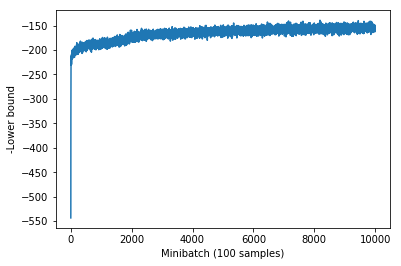

In [20]:
plt.ylabel("-Lower bound")
plt.xlabel("Minibatch (" + str(batch_size) + " samples)")
plt.plot(-np.array(training), label = "Train")
plt.show()

In [21]:
# Extract estimated parameters (W, b)
est_W3 = updates[1][0].get_value()
est_W1 = updates[3][0].get_value()
est_W2 = updates[5][0].get_value()
est_b_W1 = updates[7][0].get_value()
est_b_W2 = updates[9][0].get_value()

est_b3 = updates[11][0].get_value()
est_b1 = updates[13][0].get_value()
est_b2 = updates[15][0].get_value()
est_b_b1 = updates[17][0].get_value()
est_b_b2 = updates[19][0].get_value()


In [36]:
est_b3

array([-0.06548495,  0.09219416,  0.05473641, -0.0507232 ,  0.35511436,
        0.0314526 ,  0.04960862, -0.44596155, -0.08796941, -0.08170495,
       -0.0522084 , -0.03487416,  0.04396815,  0.06529486, -0.10707595,
        0.4941833 ,  0.20760385,  0.26026382, -0.01066109, -0.06096779,
        0.0153535 ,  0.05069374,  0.0339819 ,  0.08376884,  0.10539282,
       -0.07145259, -0.09645054, -0.15072911, -0.06697108, -0.52287181,
        0.29967823, -0.18646895, -0.01944464,  0.03820609,  0.17995423,
        0.08957479, -0.26644011, -0.27286374, -0.39065704, -0.0936948 ,
       -0.00447832,  0.03368777,  0.08809759,  0.01304251, -0.22245177,
       -0.00756645,  0.05468642,  0.04635136, -0.29488459, -0.078704  ,
        0.14703243, -0.07771138,  0.04562958,  0.08841962, -0.0918371 ,
       -0.07880317, -0.18081715,  0.08288066, -0.08835584,  0.00735588,
       -0.0538452 , -0.0273868 , -0.10427747, -0.01585521,  0.06025554,
        0.17611549, -0.08683606, -0.10928289,  0.30365709,  0.09

In [22]:
import numba
from numba import jit

@jit
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [24]:
est_h_encoder = np.tanh(np.dot(x_test, est_W3) + est_b3)
phi_mu = np.dot(est_h_encoder, est_W1) + est_b1
phi_log_sig2 = np.dot(est_h_encoder, est_W2) + est_b2

In [25]:
a, b =phi_log_sig2.shape 
a, b

(10000, 3)

In [26]:
z_ = phi_mu + np.sqrt(np.exp(phi_log_sig2))*np.random.randn(a, b)

In [27]:
est_h_decoder = np.tanh(np.dot(z_, est_b_W1) + est_b_b1)

In [28]:
c = np.dot(est_h_decoder, est_b_W2)

In [29]:
y_ = sigmoid(c + est_b_b2)
y_.shape

(10000, 784)

In [32]:
# Regenerate data for visualization
p = y_.mean(axis =0)
y_.shape

(10000, 784)

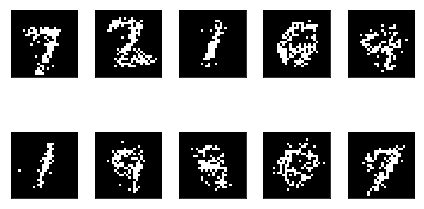

In [34]:
x_new = np.random.binomial(1,y_,[10000,784])
x_new = x_new.reshape([10000, 28, 28])
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_new[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

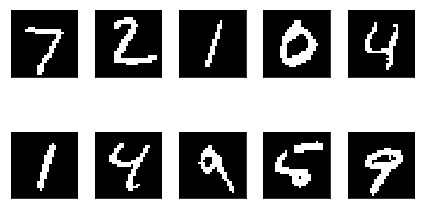

In [37]:
x_test = x_test.reshape([10000, 28, 28])
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_test[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [21]:
t = T.vector()
h = T.tanh(T.dot(t, bernoulli_W1) + bernoulli_b1)
yt = T.nnet.sigmoid(T.dot(h, bernoulli_W2) + bernoulli_b2)
visualize = theano.function([t], yt,
                            mode='FAST_RUN',
                            allow_input_downcast=True)

In [ ]:
'''gaussian decoder and freyface starts next:'''

In [8]:
from scipy.io import loadmat
ff = loadmat('frey_rawface.mat', squeeze_me=True, struct_as_record=False)
ff1 = ff["ff"].T

In [10]:
f_train=ff1[:1500,]
f_test=ff1[1501:,]

In [28]:
x=f_train

In [36]:
x.shape[1]

560

In [ ]:
std_normal = T.matrix("std_normal") 
z = mu + T.sqrt(T.exp(log_sig2))*std_normal
h_decoder = T.tanh(T.dot(z, W6) + b6)
mu_prime = T.dot(h_decoder, W4) + b4
log_sig2_prime = T.dot(h_decoder, W5) + b5

In [35]:
T.sum(log_sig2_prime)

Sum{acc_dtype=float64}.0

In [33]:
log_sig2_prime.sum(axis=1)

Sum{axis=[1], acc_dtype=float64}.0

In [37]:
# our logpxz

-0.5*(x.shape[1]*np.log(2*np.pi))-0.5*(log_sig2_prime.sum(axis=1))-0.5*(x-mu_prime)**2/(np.exp(log_sig2_prime)).sum(axis=1)

Elemwise{sub,no_inplace}.0

In [40]:
#from VAE github:y0st
# had to change axis=2 to 1,  SOOO unreliable this guy!!  I would use ours!
logpxz = (-(0.5 * np.log(2 * np.pi) + 0.5 * log_sig2_prime) - 0.5 * ((x - mu_prime)**2 / T.exp(log_sig2_prime))).sum(axis=1).mean(axis=0)
logpxz

mean

In [26]:
# Parameters
# Gaussian MLP weights and biases (decoder)
#initialize \theta

b6 = init_w((n_hidden, ))
b5 = init_w((n_input, ))
b4 = init_w((n_input, ))


W6 = init_w((n_latent, n_hidden))
W5 = init_w((n_hidden, n_input))
W4 = init_w((n_hidden, n_input))

In [16]:
# Gaussian Decoder               --- ours!!!
std_normal = T.matrix("std_normal") 
z = mu + T.sqrt(T.exp(log_sig2))*std_normal
h_decoder = T.tanh(T.dot(z, W6) + b6)
mu_prime = T.dot(h_decoder, W4) + b4
log_sig2_prime = T.dot(h_decoder, W5) + b5
log_likelihood_gaus=-0.5*(x.shape[1]*np.log(2*np.pi))-0.5*(log_sig2_prime.sum(axis=1))-0.5*(x-mu_prime)**2/(np.exp(log_sig2_prime)).sum(axis=1)